In [1]:
import sys
import os
import wandb
import torch
import numpy as np
import json

import pandas as pd
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from scipy.stats import entropy

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Base.lla import dgala
from Base.utilities import *

from elliptic2d_files.train_elliptic2d import train_elliptic2d,generate_data,samples_param
from elliptic2d_files.elliptic2d import Elliptic2D
#from elliptic2d_files.elliptic_mcmc import *
from elliptic2d_files.utilities import *
from elliptic2d_files.physics_informed_gp2d import EllipticPIGP
from elliptic2d_files.FEM2d_Solver import Elliptic2D_FEM,Parametric_K
from scipy.interpolate import griddata, interp2d


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Elliptic 2D

$$-\nabla \cdot (a(x,\theta)\nabla u(x,\theta)) = 4x_{1}x_{2}, \quad x\in (0,1)^{2},\theta \in [-1,1]^{N}$$
$$u(x) = 0 \quad x \in \partial D$$

where $a(x,\theta)$ has the following form:
 
$$  
a(x,\theta) = \mu_{a}  +  \sum_{i,j=1}^{k_{i}, k_{j}} \sqrt a_{i,j} \theta_{i,j} b_{i,j}(x)  
$$

where $a_{n} = \frac{1}{4}\exp(- \pi (i^{2}+ j^{2})l^{2})$ and $b_{i,j} = 2 \cos(i \pi x_{1})\cos(j \pi x_{2})$.

In [2]:

def error_norm_mean(surrogate, fine_model,observation_locations,samples, device, solver = True, gp=False):
    total_error = 0
    for theta in samples:

        if solver:
            fine_model.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
            fine_model.solve()
            surg = fine_model.evaluate_at_points(observation_locations.cpu().numpy()).reshape(-1, 1)
            fine_pred = torch.tensor(surg, device=device)
        else:
            fine_pred = fine_model.prediction(theta.reshape(1,-1),var=False)


        if gp and solver:
            surrogate_pred = surrogate.prediction(theta.reshape(1,-1),var=False)
            
        else:
            data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
            surrogate_pred = surrogate.u(data.float()).detach()

        
        error = torch.linalg.norm((fine_pred.reshape(-1,1)-surrogate_pred.reshape(-1,1)),ord=2).item()
        total_error += error

    return total_error / samples.shape[0]

In [11]:
# Example data
bins = 80
NN_config = [250]
GP_config = [250]
KLs = [3]

nn_results = {}
dgala_results = {}

gp_results = {}
gp_marginal_results = {}

for gp_config,kl in zip(GP_config,KLs):
    nn_results[f"kl_{kl}"]={}
    gp_results[f"kl_{kl}"]={}

    eval = samples_param(100,kl)


    if kl >2:
        model_specific = f"_hl3_nn250_s10000_bs800_kl{kl}"
    else:
        model_specific = f"_hl3_nn150_s1000_bs250_kl{kl}"


    path_nn_model = f"./models/elliptic2d"+model_specific+".pth"

    nn_surrogate_model = torch.load(path_nn_model)
    nn_surrogate_model.eval()

    # llp = torch.load(path_dgala_model, map_location=device)
    # llp.model.set_last_layer("output_layer")  # Re-register hooks
    # llp._device = device

    data_training,obs_points,_ = pigp_training_data_generation(gp_config,6,kl,1e-4,device)
    obs_points = torch.tensor(obs_points)

    # elliptic_gp = EllipticPIGP(data_training,device=device)
    # elliptic_gp.train_gp()
    # elliptic_gp.optimize_mll()
    # torch.save(elliptic_gp, f"./models/elliptic2d_pigp__spatial6_nsol{gp_config}_kl{kl}.pt.pt")
    
    elliptic_gp = torch.load(f"./models/elliptic2d_pigp__spatial6_nsol{gp_config}_kl{kl}.pt")

    # nn_post_eval = stat_ar(nn_post_eval, every=5000)[-1]
    # gp_post_eval = stat_ar(gp_post_eval, every=5000)[-1]

    times_nn,times_gp = [], []
    for evl in eval:
        theta = torch.tensor(evl).reshape(1,-1)

        data = torch.cat([obs_points, theta.repeat(obs_points.size(0), 1)], dim=1).float()
        
        train_timer = Timer(use_gpu=True)
        train_timer.start()
        surg = nn_surrogate_model.u(data)
        ttrain = train_timer.stop()
        times_nn.append(ttrain)

        train_timer = Timer(use_gpu=True)
        train_timer.start()
        mean = elliptic_gp.prediction(theta,var=False)
        ttrain = train_timer.stop()
        times_gp.append(ttrain)


    nn_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_nn),np.std(times_nn))
    gp_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_gp),np.std(times_gp))

    samples_th = torch.normal(mean=0, std=1, size=(10000,kl))

    
    fem_solver = Elliptic2D_FEM(np.zeros(kl), ncells=50)
    error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,samples_th, device)
    nn_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,samples_th, device, gp=True)
    gp_results[f"kl_{kl}"]["m0_error"] = error_mcmc


    chain_fem = np.load(f'./results/e2dFEM_kl{kl}_var0.0001.npy')

    nn_ind_res = {"w1":[],"post":[],"bound":[]}
    gp_ind_res = {"w1":[],"post":[],"bound":[]}

    fem_solver = Elliptic2D_FEM(np.zeros(kl), ncells=50)
    error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,torch.tensor(chain_fem)[-10000:,:], device)
    nn_results[f"kl_{kl}"]["m_error"] = error_mcmc

    error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,torch.tensor(chain_fem)[-10000:,:], device, gp=True)
    gp_results[f"kl_{kl}"]["m_error"] = error_mcmc

    for i in range(4):
        chain_nn = np.load(f'./results/NN'+model_specific+f'_var0.0001_{i}.npy')
        nn_post_eval = np.load(f"./results/mcmc_da_nn"+model_specific+f"_0.0001_{i}.npy")

        chain_gp = np.load(f"./results/PIGP2D_mean_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        gp_post_eval = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{gp_config}_kl{kl}_0.0001_{i}.npy")

        # w1_nn = discrete_W1(chain_nn,chain_fem)
        # nn_ind_res["w1"].append(w1_nn)
        
        w1_gp = discrete_W1(chain_gp,chain_nn)
        gp_ind_res["w1"].append(w1_gp)

        nn_ind_res["post"].append(nn_post_eval.sum()/nn_post_eval.shape[-1])
        gp_ind_res["post"].append(gp_post_eval.sum()/gp_post_eval.shape[-1])

        solver_val = np.load(f"./results/mcmc_da_pigp2d_mean_lh_solver_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        surrogate_val = np.load(f"./results/mcmc_da_pigp2d_mean_lh_nn_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")

        dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        mean_dif = dif.mean()
        gp_ind_res["bound"].append(mean_dif)

        solver_val = np.load(f"./results/mcmc_da_nn_lh_solver"+ model_specific+ f"_var0.0001_{i}.npy")
        surrogate_val = np.load(f"./results/mcmc_da_nn_lh_nn"+ model_specific+ f"_var0.0001_{i}.npy")

        dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        mean_dif = dif.mean()
        nn_ind_res["bound"].append(mean_dif)


    nn_mean, nn_std = (np.mean(nn_ind_res["w1"]),np.std(nn_ind_res["w1"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["w1"]),np.std(gp_ind_res["w1"]))

    nn_results[f"kl_{kl}"]["w1"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["w1"] = (gp_mean, gp_std)
    
    nn_mean, nn_std = (np.mean(nn_ind_res["post"]),np.std(nn_ind_res["post"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["post"]), np.std(gp_ind_res["post"]))

    nn_results[f"kl_{kl}"]["post_eval"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["post_eval"] = (gp_mean, gp_std)

        
    nn_mean, nn_std = (np.mean(nn_ind_res["bound"]),np.std(nn_ind_res["bound"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["bound"]), np.std(gp_ind_res["bound"]))

    nn_results[f"kl_{kl}"]["bound"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["bound"] = (gp_mean, gp_std)

    error_mcmc = error_norm_mean(nn_surrogate_model, elliptic_gp,obs_points ,torch.tensor(chain_fem)[-10000:,:], device,solver=False, gp=False)
    gp_results[f"kl_{kl}"]["nn_gp"] = error_mcmc

In [12]:
gp_results

{'kl_3': {'eval_time': (0.0001890107404324226, 3.8224065197961076e-05),
  'm0_error': 0.022374463301046976,
  'm_error': 0.01408372068563449,
  'w1': (0.0466766826171875, 0.00392942443267797),
  'post_eval': (0.963585, 0.00014874474780642626),
  'bound': (0.00057496, 2.8368531e-06),
  'nn_gp': 0.000993442866102324}}

In [13]:
nn_results

{'kl_3': {'eval_time': (0.0002668653623550199, 5.191452588290577e-05),
  'm0_error': 0.02221963381300528,
  'm_error': 0.014005476767653326,
  'w1': (nan, nan),
  'post_eval': (0.9507525, 0.0007823482280928505),
  'bound': (0.0010191593, 1.1329834e-05)}}

In [8]:
nn_results

{'kl_5': {'eval_time': (0.00027634315978502854, 4.348143250192961e-05),
  'm0_error': 0.006717550422090832,
  'm_error': 0.0025143114961476837,
  'w1': (nan, nan),
  'post_eval': (0.8853325000000001, 0.0010157601833110242),
  'bound': (0.0026856498, 1.1796119e-05)}}

In [9]:
gp_results

{'kl_5': {'eval_time': (0.00019168862869264558, 2.768581148463401e-05),
  'm0_error': 0.004271198798008987,
  'm_error': 0.001010108222881446,
  'w1': (0.07520683691406249, 0.009720713468331805),
  'post_eval': (0.9427099999999999, 0.0013153896761036326),
  'bound': (0.0010409718, 4.9797263e-06),
  'nn_gp': 0.002807151051406079}}

In [5]:
nn_results

{'kl_2': {'eval_time': (0.00016500950907357036, 3.219321010507308e-05),
  'm0_error': 0.001249873733626154,
  'm_error': 0.0003159232878636022,
  'w1': (nan, nan),
  'post_eval': (0.9768749999999999, 0.00016039014932343917),
  'bound': (0.0003530227, 2.5412978e-06)},
 'kl_4': {'eval_time': (0.0002666503601358272, 3.527743882962546e-05),
  'm0_error': 0.02243176647676469,
  'm_error': 0.015180365371649834,
  'w1': (nan, nan),
  'post_eval': (0.9569225, 0.0009885437521930894),
  'bound': (0.0008446004, 8.634642e-06)},
 'kl_5': {'eval_time': (0.00030040352081414315, 4.08328053866745e-05),
  'm0_error': 0.006726762676857105,
  'm_error': 0.0025143114961476837}}

In [6]:
gp_results

{'kl_2': {'eval_time': (0.0001351280402741395, 1.981174776717826e-05),
  'm0_error': 0.0018478708481826618,
  'm_error': 0.00040719806154677934,
  'w1': (0.0245277861328125, 0.004201958605812855),
  'post_eval': (0.971265, 0.0008021377687155687),
  'bound': (0.0004629141, 2.3026064e-06),
  'nn_gp': 0.000366371050013802},
 'kl_4': {'eval_time': (0.00018359904846874996, 1.7979531878417382e-05),
  'm0_error': 0.02298171092515145,
  'm_error': 0.015186001429185183,
  'w1': (0.011222635620117188, 0.002471435237648495),
  'post_eval': (0.9460250000000001, 0.0004129467277991116),
  'bound': (0.00091372785, 3.3129504e-06),
  'nn_gp': 0.0010678883806980626},
 'kl_5': {'eval_time': (0.0002061740984208882, 2.4162634015857278e-05),
  'm0_error': 0.00426648208231422,
  'm_error': 0.001010108222881446}}

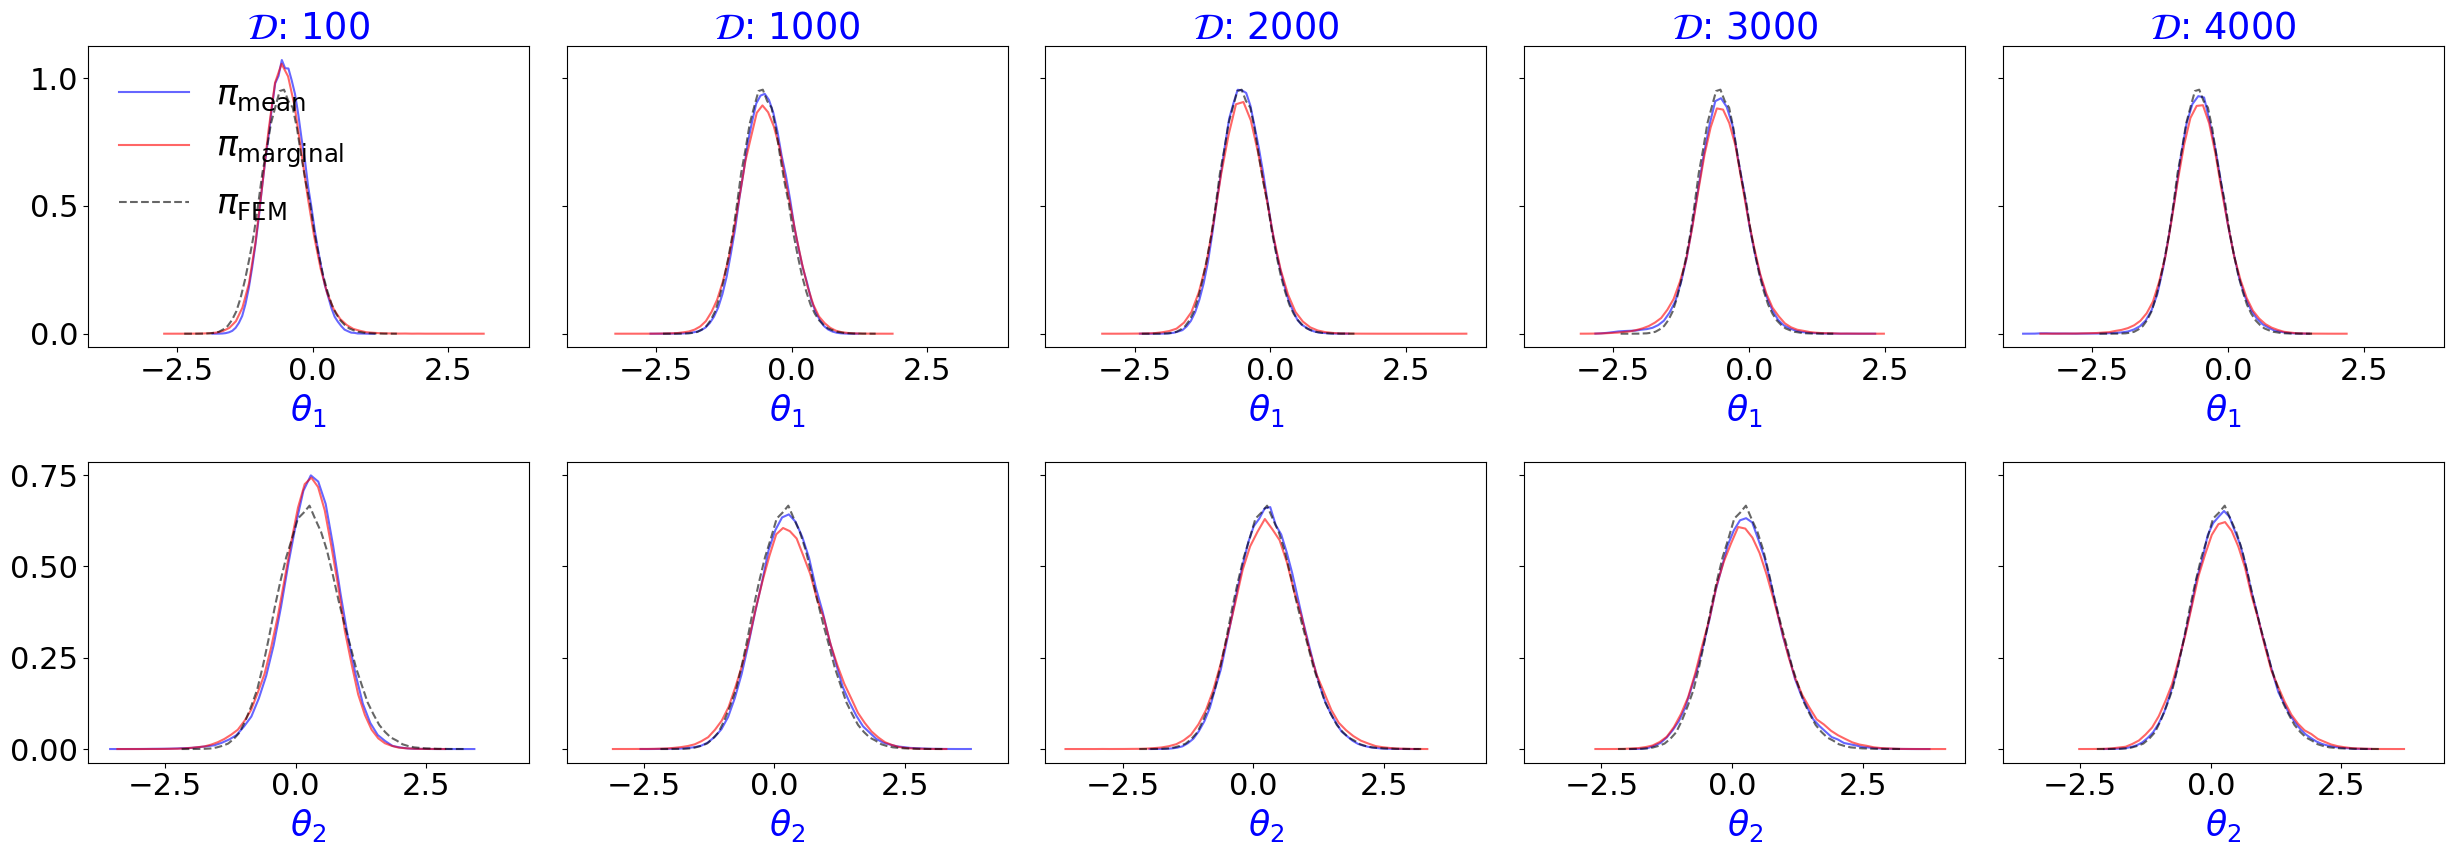

In [6]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#N = [100, 250, 500, 1000, 1500, 2500, 4000, 5000]
N = [100,1000,2000,3000,4000]
bins = 50
kl = 2
nn = 150

fig, axs = plt.subplots(2,len(N), figsize=(25, 9), sharey="row", sharex="row")
#fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 22})

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/NN_hl{3}_nn{nn}_s{nobs}_bs{250}_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_hl{3}_nn{nn}_s{nobs}_bs{250}_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/e2dFEM_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")
    # axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    # axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)
    # axs[0,i].set_xlim((-.5,0.8))
    # axs[1,i].set_xlim((0.2,0.55))
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)


axs[0,0].legend(frameon = False, prop={'size': 25},loc='upper left')
# axs[0, 0].legend(
#     frameon=False,
#     prop={'size': 15},
#     loc='upper right',
#     bbox_to_anchor=(3.7, 1)  # Adjust position as needed
# )
#axs[-1,0].set_xlim((-0.3,0.6)),axs[-1,1].set_xlim((0.25,0.5))
plt.tight_layout()
plt.savefig(f"./results/images/elliptic2d_pd_kl{kl}_{vr}.pdf", bbox_inches='tight') 

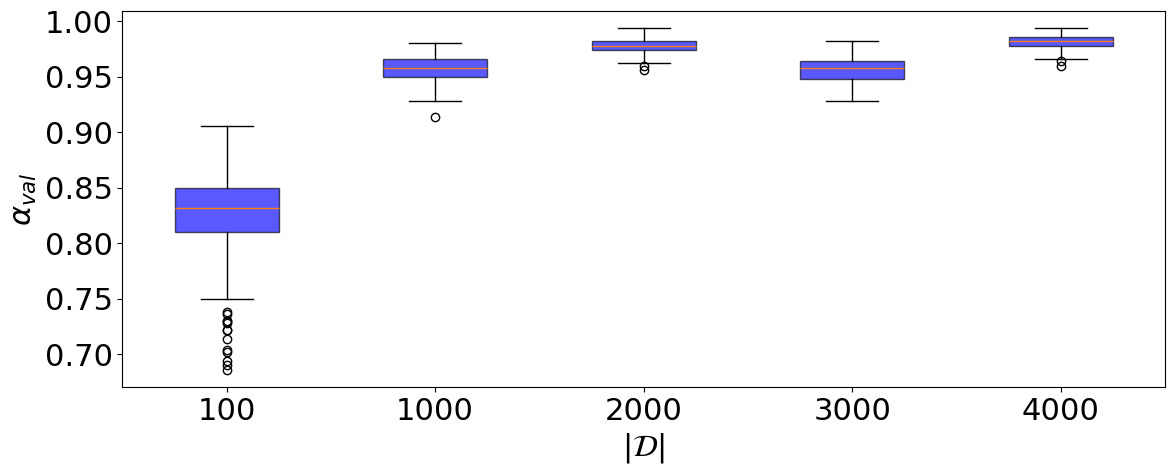

In [22]:
N = [100,1000,2000,3000,4000]

acceptance_mean_list = np.array([stat_ar(np.load(f"./results/mcmc_da_nn_hl3_nn150_s{n}_bs{250}_kl{kl}_{vr}.npy"),every=500)[-1] for n in N])
cl = ["red", "blue", "green", "orange", "black","orange","tomato"]

fig, axs = plt.subplots(1, figsize=(12, 5), sharex="col")
plt.rcParams.update({'font.size': 15})

bplot = axs.boxplot(acceptance_mean_list.T,patch_artist=True, labels=[str(n) for n in N])  # Transpose to plot along axis 1
#plt.suptitle(f"Acceptance Rate for different NN",color = "blue")
# fill with colors
for patch, color in zip(bplot['boxes'], cl):
    patch.set_facecolor("blue")
    patch.set_alpha(0.65)
    patch.set_linewidth(1)

# Customize the plot
axs.set_xlabel("$|\\mathcal{D}|$")
axs.set_ylabel("$\\alpha_{val}$")
#plt.ylim((0,0.5))
# Save the plotx
plt.savefig(f"./results/images/elliptic2d_da_ar_kl{kl}_{vr}.pdf")
axs.legend(frameon =False)
plt.tight_layout()
plt.show()

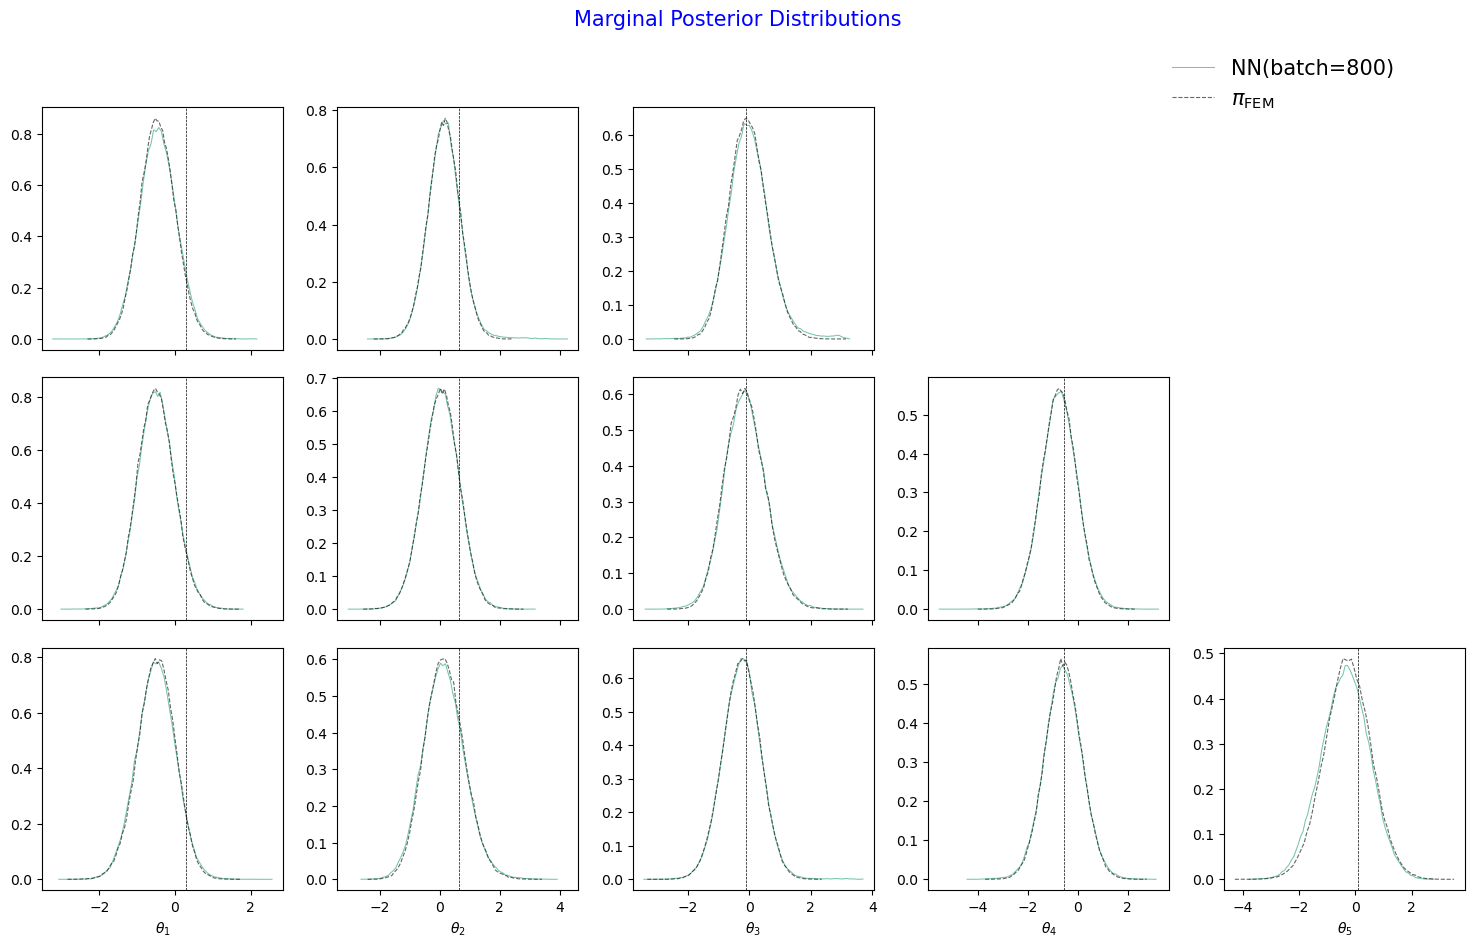

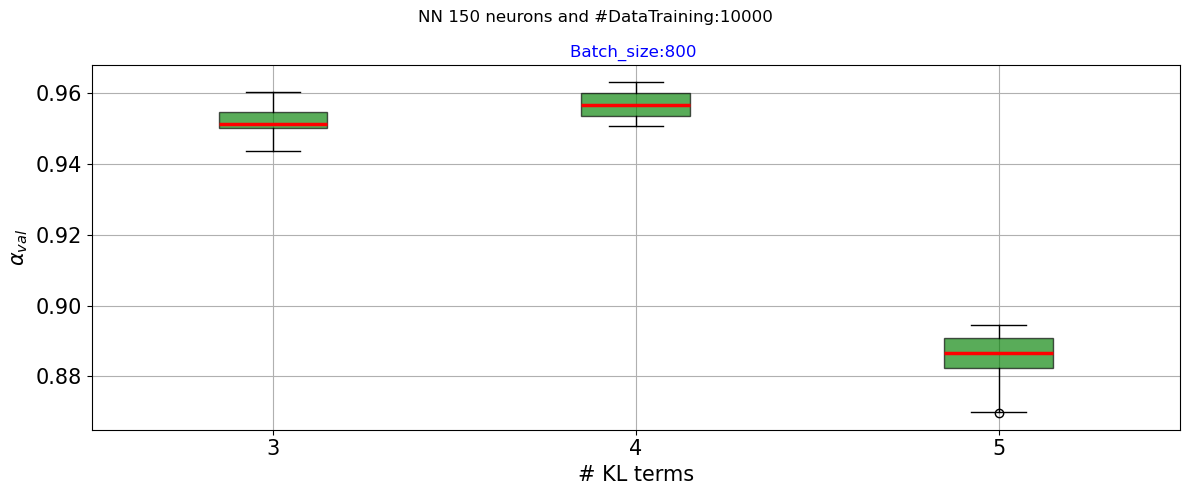

In [5]:
vr = 1e-4
_, _,theta_th = generate_noisy_obs(6, 20)

nobs = 10000  # All N you want to plot
kl = [3,4,5]
bins = 80
#100 160 200 250 400 500
batches = [800]

colors = plt.cm.Dark2(np.linspace(0, 1, len(batches)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,batch in enumerate(batches):
        try:
            sample_nn = np.load(f'./results/NN_hl3_nn{250}_s{nobs}_bs{batch}_kl{k}_var{vr}_0.npy')
        except FileNotFoundError:
            print(f"Warning: file for N={nobs}, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_nn[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"NN(batch={batch})" if j == 0 else None)  # Label only once per N
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/e2dFEM_kl{k}_var{vr}.npy')

                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"./results/images/elliptic2d_pd_kls_batches_var{vr}.pdf")


# For each kl, collect acceptance means across N
acceptance_mean_list = []

for kls in kl:
    tmp = []
    for batch in batches:
        data = np.load(f"./results/mcmc_da_nn_hl3_nn{250}_s{nobs}_bs{batch}_kl{kls}_{vr}_0.npy")
        stat = stat_ar(data, every=5000)[-1]
        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(batches),figsize=(12, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})
fig.suptitle(f"NN 150 neurons and #DataTraining:{nobs}")
# Create boxplot
for i,batch in enumerate(batches):
    bplot = ax.boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax.set_ylabel("$\\alpha_{val}$")
    ax.set_title(f"Batch_size:{batch} ", color="blue")
    ax.grid(True)
    ax.set_xlabel("# KL terms")


plt.savefig(f"./results/images/elliptic2d_da_ar_kls_batches_{vr}.pdf", bbox_inches='tight')
plt.tight_layout()

# axs.legend(frameon =False)

# plt.show()

TypeError: 'Axes' object is not subscriptable

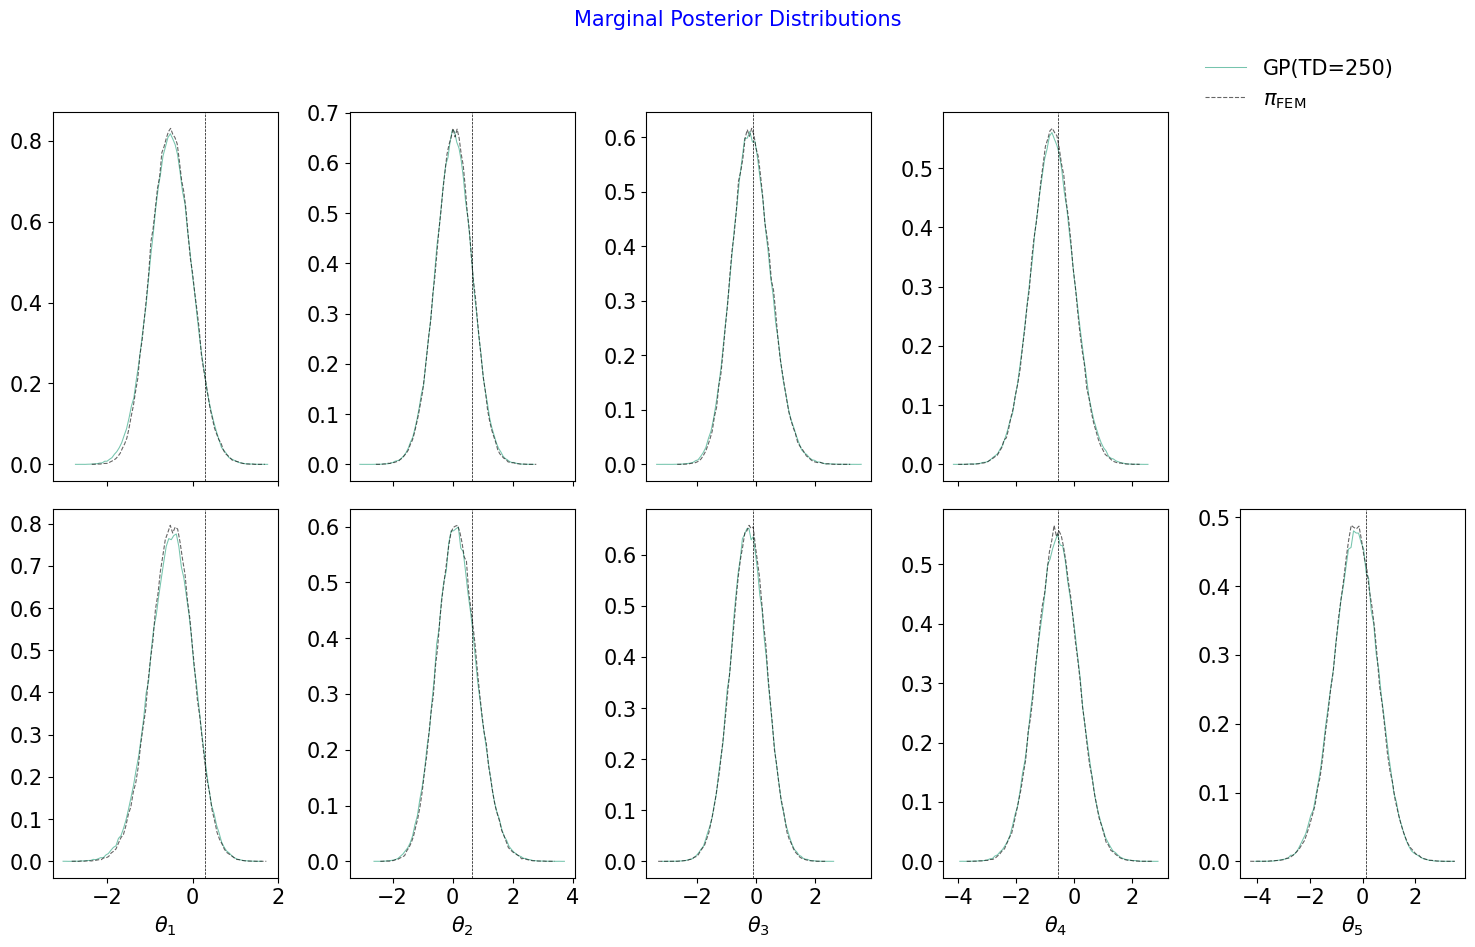

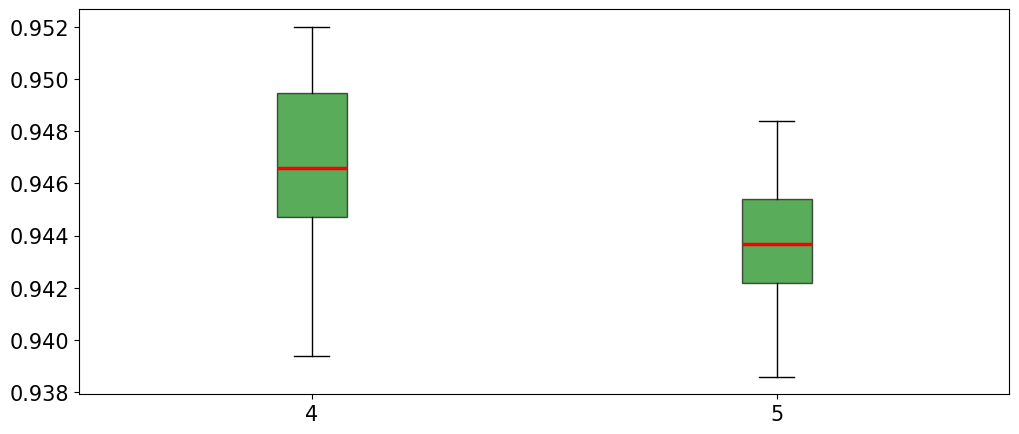

In [7]:
vr = 1e-4
_, _,theta_th = generate_noisy_obs(6, 20)

nobs = 4000  # All N you want to plot
kl = [4,5]
bins = 80
#100 160 200 250 400 500
batches = [250]

colors = plt.cm.Dark2(np.linspace(0, 1, len(batches)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,batch in enumerate(batches):
        try:
            sample_nn = np.load(f'./results/PIGP2D_mean_spatial6_nsol{batch}_kl{k}_var{vr}_0.npy')
        except FileNotFoundError:
            print(f"Warning: file for N={nobs}, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_nn[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"GP(TD={batch})" if j == 0 else None)  # Label only once per N
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/e2dFEM_kl{k}_var{vr}.npy')

                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"./results/images/elliptic2d_pigp2d_pd_kls_samples{batches}_var{vr}.pdf")


# For each kl, collect acceptance means across N
acceptance_mean_list = []

for kls in kl:
    tmp = []
    for batch in batches:
        data = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{batch}_kl{kls}_{vr}_0.npy")
        stat = stat_ar(data, every=5000)[-1]

        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(batches),figsize=(12, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})
#fig.suptitle("NN 100 neurons and #DataTraining:4,000")
# Create boxplot
for i,batch in enumerate(batches):
    bplot = ax.boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax[i].set_ylabel("$\\alpha_{val}$")
    ax[i].set_title(f"NTraining_Data:{batch} ", color="blue")
    ax[i].grid(True)
    ax[i].set_xlabel("# KL terms")
    ax[i].set_ylim(0.5,1)


plt.savefig(f"./results/images/elliptic2d_pigp2d_da_ar_kls_samples{batches}_{vr}.pdf", bbox_inches='tight')
plt.tight_layout()

# axs.legend(frameon =False)
# plt.show()

In [58]:
data = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{250}_kl{5}_{vr}.npy")
stat = stat_ar(data, every=5000)[-1]
stat.mean()

0.9434899